In [11]:
import cvxpy as cp
import json

# 저자

- TA: 성준모 (Joonmo Sung)
- SYSTEMS MODELING AND PROGRAMMING LAB DEPARTMENT OF INDUSTRIAL ENGINEERING, YONSEI UNIVERSITY - SYMPLY
- 문의: `sjm21314@naver.com`,`sjm21314@yonsei.ac.kr`
***
본 강의자료는 Keha,A. B.,Khowala,K.,&Fowler,J. W. (2009). Mixed integer programming formulations for single machine scheduling problems. Computers & Industrial Engineering, 56(1), 357-367 논문을 바탕으로 제작되었으며,

반도체데이터사이언스 협동과정 수업 용도 이외의 목적으로 저자의 허락 없이 다른 사람들과 공유할 수 없습니다.

## Dataset
### Set
- J = $\{1,2,...,n\}, j \in J$ (Job)
- $\mu$ = $\{1,2, ..., m\}, i \in \mu$ (Machine)
### Parameters
- $p_j$: processing time of job $j$
- $d_j$: due date of job $j$
- $w_j$: weight of job $j$
- $r_j$: release date of job $j$

In [12]:
with open('data.json') as file:
    data = json.load(file)

In [13]:
print(len(data['N']))
print(data['p'])
print(data['d'])
print(data['w'])
print(data['r'])

5
{'0': 1, '1': 15, '2': 12, '3': 13, '4': 9}
{'0': 30, '1': 5, '2': 15, '3': 22, '4': 40}
{'0': 6, '1': 3, '2': 2, '3': 5, '4': 2}
{'0': 22, '1': 16, '2': 15, '3': 4, '4': 10}


In [14]:
# Offline 상황을 가정.

n = len(data['N']) # 작업의 개수
m = 2 # 기계의 개수 

# Sets
J = [_ for _ in range(n)] # 작업 set을 리스트 자료구조를 이용해 0, 1, 2,..., n-1 까지 담아줌
Mu = [_ for _ in range(m)] # 기계 set을 리스트 자료구조를 이용해 0, 1, 2,..., m-1 까지 담아줌

# Parameters
p = [data['p'][f'{i}'] for i in J] # 작업의 가공시간 데이터를 리스트 자료구조를 이용해 만들어 줌
d = [data['d'][f'{i}'] for i in J] # 작업의 마감 기한 데이터를 리스트 자료구조를 이용해 만들어 줌
w = [data['w'][f'{i}'] for i in J] # 작업의 가중치 데이터를 리스트 자료구조를 이용해 만들어 줌
r = [data['r'][f'{i}'] for i in J] # 작업의 release date(도착 시점) 데이터를 리스트 자료구조를 이용해 만들어 줌

M = (sum(p) + sum(r)) * 2 # big M

In [15]:
print(p)
print(d)
print(w)
print(r)

[1, 15, 12, 13, 9]
[30, 5, 15, 22, 40]
[6, 3, 2, 5, 2]
[22, 16, 15, 4, 10]


In [16]:
obj_select = 'wct' # 'wct', 'tj', 'twt', 'L_max' 'C_max' 중 하나 선택
release_time = True

# Identical Parallel machines (Pm) 상황을 가정

## M4 - Linear ordering model formulation

### Decision Variables
- $\delta_{l,j}$: 작업 $l$가 작업 $j$보다 앞에서 시작하면 1, 아니면 0인 이진변수, $\delta_{l,j} \in \{0, 1\} \ \forall l \in J, \forall j \in J$
- $z_{l,i}$: 작업 $l$이 기계 $i$에 할당되면 1, 아니면 0인 이진변수, $z_{l,i} \in \{0, 1\} \quad \forall l \in J, \forall i \in \mu $
- $y_{l,j}$: 작업 $l$이 작업 $j$와 다른 기계에 있으면 1, 아니면 0인 이진변수, $ y_{l,j} \in \{0, 1\} \quad \forall l \in J, \forall j \in J$

In [17]:
# Decision Variable 만들기
delta = {(l, j): cp.Variable(boolean = True, name = f"delta_{l+1}_{j+1}") for l in J for j in J}
z = {(l, i): cp.Variable(boolean = True, name = f"z_{l+1}_{i+1}") for l in J for i in Mu}
y = {(l, j): cp.Variable(boolean = True, name = f"y_{l+1}_{j+1}") for l in J for j in J}
C = {(j): cp.Variable(nonneg = True, name = f"C_{j+1}") for j in J}

### 기본 constraint
- $\delta_{l,j} + \delta_{j,l} + y_{l,j} = 1 \quad \forall l \in J, \forall j \in J, l < j$
- $\delta_{l,j} + \delta_{j,k} + \delta_{k,l} \leq 2 \quad \forall l,j,k \in J, l < j < k $
- $z_{l,i} + z_{j,i} + y_{l,j} \leq 2 \quad \forall l \in J, \forall j \in J, l < j, \forall i \in \mu$
- $\sum_{i \in \mu}z_{l,i} = 1 \quad \forall l \in J$
- $C_j \geq p_jz_{j,i} \quad \forall j \in J, \forall i \in \mu$
- $C_j \geq C_l + p_j(\delta_{l,j} + z_{l,i} + z_{j,i} - 2) - M(1 - \delta_{l,j}) \quad \forall l \in J, \forall j \in J, \forall i \in \mu$

In [18]:
constraints = []

constraints += [delta[l,j] + delta[j,l] + y[l,j] == 1 for l in J for j in J if l < j]
constraints += [delta[l,j] + delta[j,k] + delta[k,l] <= 2 for l in J for j in J for k in J if l < j < k]
constraints += [z[l,i] + z[j,i] + y[l,j] <= 2 for i in Mu for l in J for j in J if l < j]
constraints += [sum(z[l,i] for i in Mu) == 1 for l in J]
constraints += [C[j] >= p[j]*z[j,i] for i in Mu for j in J]
constraints += [C[j] >= C[l] + p[j]*(delta[l,j] + z[l,i] +z[j,i] - 2) - M*(1-delta[l,j]) for i in Mu for l in J for j in J]

#### Release time 반영 제약식
$C_j \geq r_j + p_jz_{j,i} \quad \forall j \in J, \forall i \in \mu$

In [19]:
if release_time == True:
    
    constraints += [C[j] >= r[j] + p[j]*z[j,i] for i in Mu for j in J]

#### To minimize the total weighted completion time
- $ Minimize \sum_{j \in J} w_j C_j$

In [20]:
if obj_select == "wct":

    # 목적식
    obj = cp.Minimize(sum(w[j] * C[j] for j in J))

#### To minimize the total weighted tardiness

- $ Minimize \sum_{j \in J} w_j T_j$
- $ T_j \geq C_j - d_j \quad \forall j \in J $

In [21]:
if obj_select == "twt":
    
    # 작업의 종료 시점을 나타내는 T_j 선언
    T = {(j): cp.Variable(nonneg = True, name = f"T_{j+1}") for j in J}

    # T_j 제약식 추가
    constraints += [T[j] >= C[j] - d[j] for j in J]

    # 목적식
    obj = cp.Minimize(sum(w[j] * T[j] for j in J))

#### To minimize $L_{max}$
- $ Minimize \ L_{max}$
- $ L_{max} \geq (C_j - d_j) \quad \forall j \in N$

In [22]:
if obj_select == "L_max":
     
    # L_max 선언
    L_max = cp.Variable(name= "L_max") # L_max를 나타내는 연속형 변수

    # L_max 제약식
    constraints += [L_max >= C[j] - d[j] for j in J]
    # 목적식
    obj = cp.Minimize(L_max)

#### To minimize the number of tardy jobs
- $ Minimize \ \sum_{j \in J}U_j$
- $ C_j \leq d_j + MU_j \quad \forall j \in J$
- $ U_j \in \{0, 1\}$

In [23]:
if obj_select == "tj":
    
    # 작업의 종료 시점을 나타내는 U_j 선언
    U = {(j): cp.Variable(boolean = True, name = f"U_{j+1}") for j in J}

    # U_j 제약식 추가
    constraints += [C[j] <= d[j] + M*U[j] for j in J]

    # 목적식
    obj = cp.Minimize(sum(U[j] for j in J))

#### To minimize makespan
- $ Minimize \ C_{max} $
- $ C_{max} \geq C_j \quad \forall j \in J $

In [24]:
if obj_select == 'C_max':
    # Makespan인 C_max 선언
    C_max = cp.Variable(nonneg = True, name= "C_max") 

    # C_max 제약식
    constraints += [C_max >= C[j] for j in J]

    # 목적식
    obj = cp.Minimize(C_max)

In [25]:
prob = cp.Problem(obj, constraints)
prob.solve()

Set parameter Username
Set parameter LicenseID to value 2583767
Academic license - for non-commercial use only - expires 2025-11-14


np.float64(427.0)

In [26]:
print("최적해 상태:", prob.status)
print("최적값:", prob.value)

최적해 상태: optimal
최적값: 427.0


In [27]:
for (l, j), dv in delta.items(): 
    if dv.value != None and dv.value > 1e-6: # l = j인 경우 value가 None인 경우 존재
        print(f"{dv}: {dv.value}")

delta_1_3: 1.0
delta_4_1: 1.0
delta_4_2: 1.0
delta_4_3: 1.0
delta_4_5: 1.0
delta_5_1: 1.0
delta_5_2: 1.0
delta_5_3: 1.0


In [28]:
for (l, i), dv in z.items(): 
    if dv.value != None and dv.value > 1e-6: # l = j인 경우 value가 None인 경우 존재
        print(f"{dv}: {dv.value}")

z_1_2: 1.0
z_2_1: 1.0
z_3_2: 1.0
z_4_1: 1.0
z_5_2: 1.0


In [29]:
import Gantt_Chart

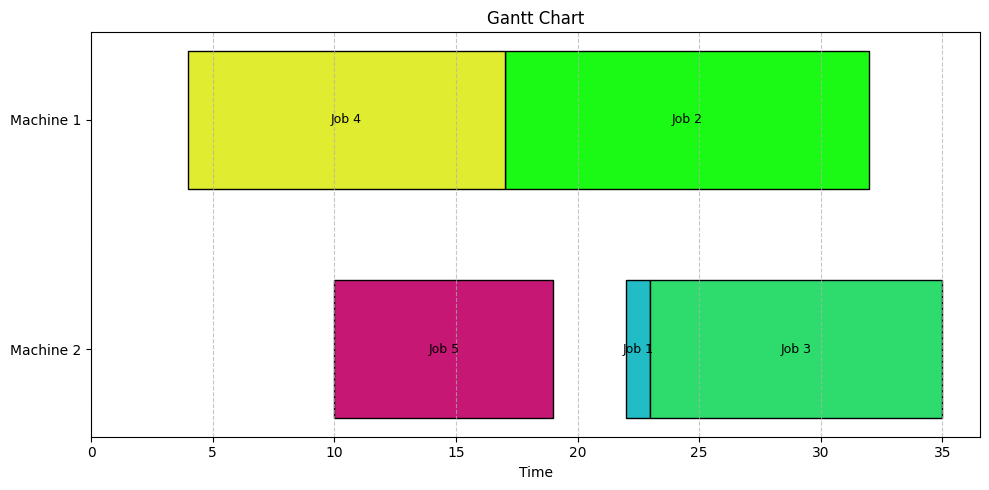

In [30]:
Gantt_Chart.M4_cvxpy_gantt(C, z, p, J, m)